#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load Dataset

In [2]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# EDA (Exploratory Data Analysis)

## Correlation Heatmap

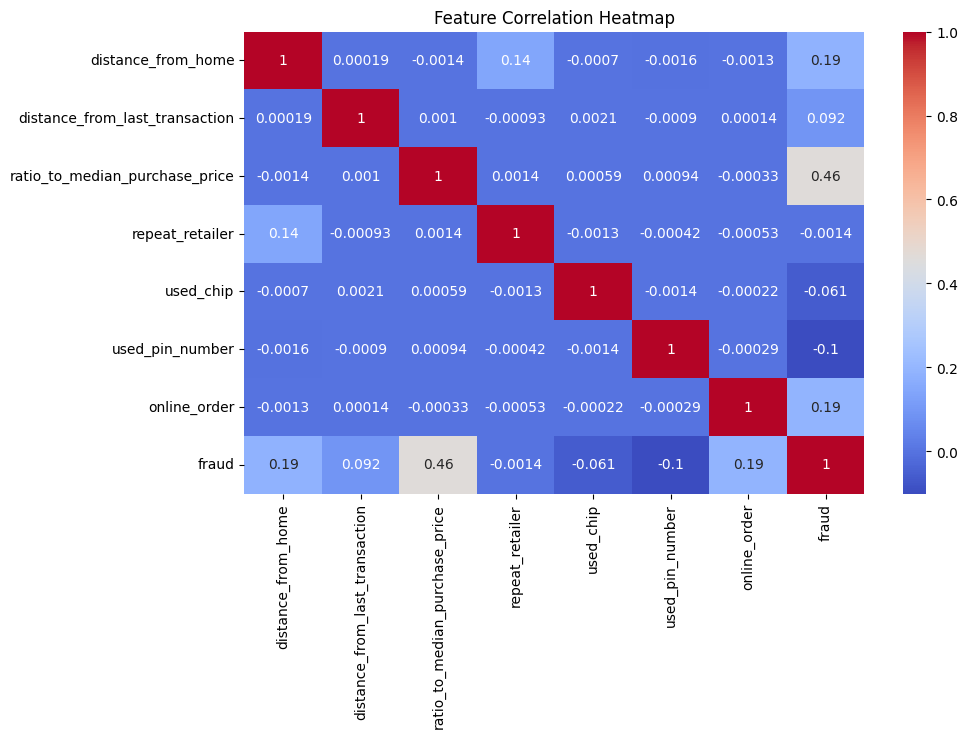

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Distribution

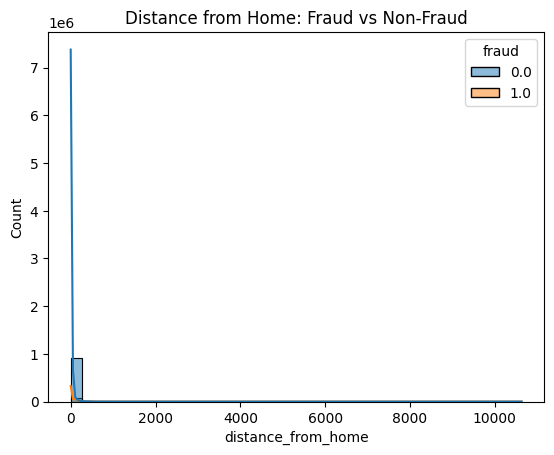

In [4]:
sns.histplot(data=df, x='distance_from_home', hue='fraud', kde=True, bins=40)
plt.title('Distance from Home: Fraud vs Non-Fraud')
plt.show()


## Count Plots

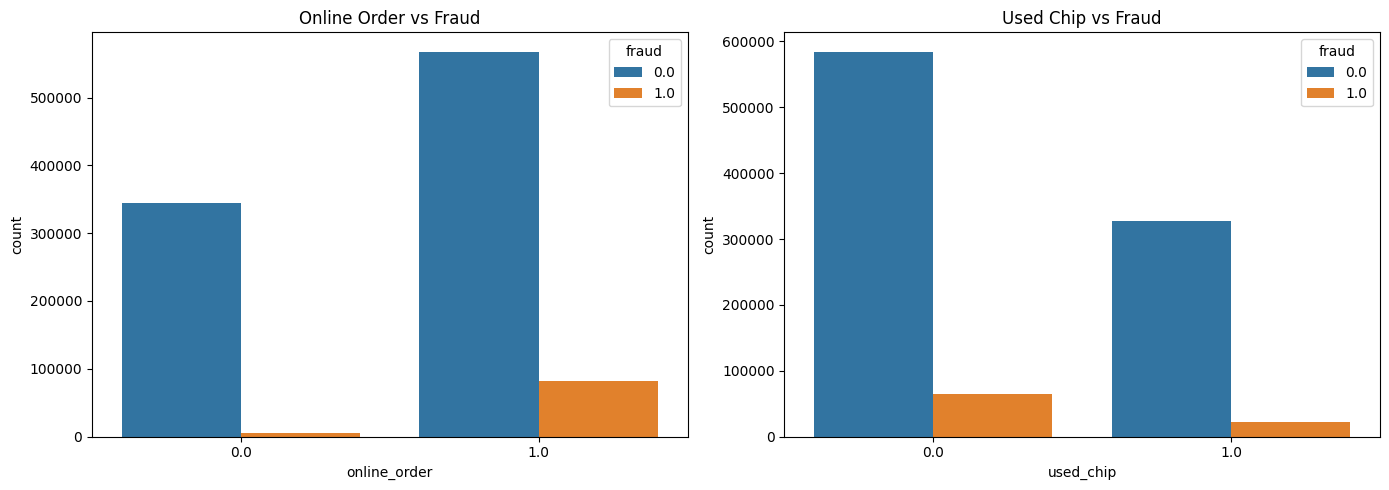

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(ax=axes[0], x='online_order', hue='fraud', data=df)
axes[0].set_title('Online Order vs Fraud')
sns.countplot(ax=axes[1], x='used_chip', hue='fraud', data=df)
axes[1].set_title('Used Chip vs Fraud')
plt.tight_layout()
plt.show()

# Preprocessing:

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

## Scaling

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Before SMOTE**

In [8]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply Models

In [9]:
log_model_imb = LogisticRegression(max_iter=1000, random_state=42)
log_model_imb.fit(X_train_imb, y_train_imb)
log_preds_imb = log_model_imb.predict(X_test_imb)
log_probs_imb = log_model_imb.predict_proba(X_test_imb)[:, 1]

rf_model_imb = RandomForestClassifier(random_state=42)
rf_model_imb.fit(X_train_imb, y_train_imb)
rf_preds_imb = rf_model_imb.predict(X_test_imb)
rf_probs_imb = rf_model_imb.predict_proba(X_test_imb)[:, 1]

xgb_model_imb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_imb.fit(X_train_imb, y_train_imb)
xgb_preds_imb = xgb_model_imb.predict(X_test_imb)
xgb_probs_imb = xgb_model_imb.predict_proba(X_test_imb)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:00:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n=== {model_name} (Before SMOTE) ===")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.6f}")

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=2))

    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC Score: {roc_auc}")

evaluate_model("Logistic Regression", y_test_imb, log_preds_imb, log_probs_imb)
evaluate_model("Random Forest", y_test_imb, rf_preds_imb, rf_probs_imb)
evaluate_model("XGBoost", y_test_imb, xgb_preds_imb, xgb_probs_imb)


=== Logistic Regression (Before SMOTE) ===
Accuracy: 0.959080
Confusion Matrix:
[[271937   1842]
 [ 10434  15787]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    273779
         1.0       0.90      0.60      0.72     26221

    accuracy                           0.96    300000
   macro avg       0.93      0.80      0.85    300000
weighted avg       0.96      0.96      0.96    300000

ROC-AUC Score: 0.9671811288299552

=== Random Forest (Before SMOTE) ===
Accuracy: 0.999983
Confusion Matrix:
[[273779      0]
 [     5  26216]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

ROC-AUC Score: 1.0

=== XGBoost (Befor

## unsupervised models

### Isolation Forest

In [11]:
iso = IsolationForest(contamination=0.05, random_state=42)
unsupervised_preds = iso.fit_predict(X_scaled)

unsupervised_preds = np.where(unsupervised_preds == -1, 1, 0)

print("=== Isolation Forest (Before SMOTE) ===")
print("Accuracy:", accuracy_score(y, unsupervised_preds))
print("Confusion Matrix:")
print(confusion_matrix(y, unsupervised_preds))
print("\nClassification Report:")
print(classification_report(y, unsupervised_preds))
print("ROC-AUC Score:", roc_auc_score(y, unsupervised_preds))

=== Isolation Forest (Before SMOTE) ===
Accuracy: 0.884389
Confusion Matrix:
[[873493  39104]
 [ 76507  10896]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94    912597
         1.0       0.22      0.12      0.16     87403

    accuracy                           0.88   1000000
   macro avg       0.57      0.54      0.55   1000000
weighted avg       0.86      0.88      0.87   1000000

ROC-AUC Score: 0.5409073847152648


### Autoencoder

In [12]:
X_normal = X_scaled[y == 0]
input_dim = X_scaled.shape[1]
encoding_dim = 5

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.fit(X_normal, X_normal, epochs=10, batch_size=32, shuffle=True, verbose=1)

reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)

threshold = np.percentile(mse[y == 0], 95)
autoencoder_preds = (mse > threshold).astype(int)  # 1 = fraud, 0 = normal

print("\n=== Autoencoder (Before SMOTE) ===")
print("Accuracy:", accuracy_score(y, autoencoder_preds))
print("Confusion Matrix:")
print(confusion_matrix(y, autoencoder_preds))
print("\nClassification Report:")
print(classification_report(y, autoencoder_preds))
print("ROC-AUC Score:", roc_auc_score(y, autoencoder_preds))

Epoch 1/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.6517
Epoch 2/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.5494
Epoch 3/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - loss: 0.6187
Epoch 4/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.5488
Epoch 5/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5974
Epoch 6/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5744
Epoch 7/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5917
Epoch 8/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.5705
Epoch 9/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 0.5500
Epoch 10/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.5395
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step

=== Autoencoder (Before SMOTE) ===
Accuracy: 0.882632
Confusion Matrix:
[[866967  45630]
 [ 71738  15665]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94   

# **After SMOTE**

In [13]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

## PCA

In [14]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_resampled)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.3, random_state=42)

# Train Supervised Models

## Logistic Regression

In [16]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

## Random Forest


In [17]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

## XGBoost

In [18]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Evaluation Function


Logistic Regression Results
[[250869  23078]
 [ 20887 252725]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    273947
         1.0       0.92      0.92      0.92    273612

    accuracy                           0.92    547559
   macro avg       0.92      0.92      0.92    547559
weighted avg       0.92      0.92      0.92    547559

AUC Score: 0.9197097007108184

Random Forest Results
[[273584    363]
 [    26 273586]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273947
         1.0       1.00      1.00      1.00    273612

    accuracy                           1.00    547559
   macro avg       1.00      1.00      1.00    547559
weighted avg       1.00      1.00      1.00    547559

AUC Score: 0.9992899505499255

XGBoost Results
[[273058    889]
 [    64 273548]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273947
   

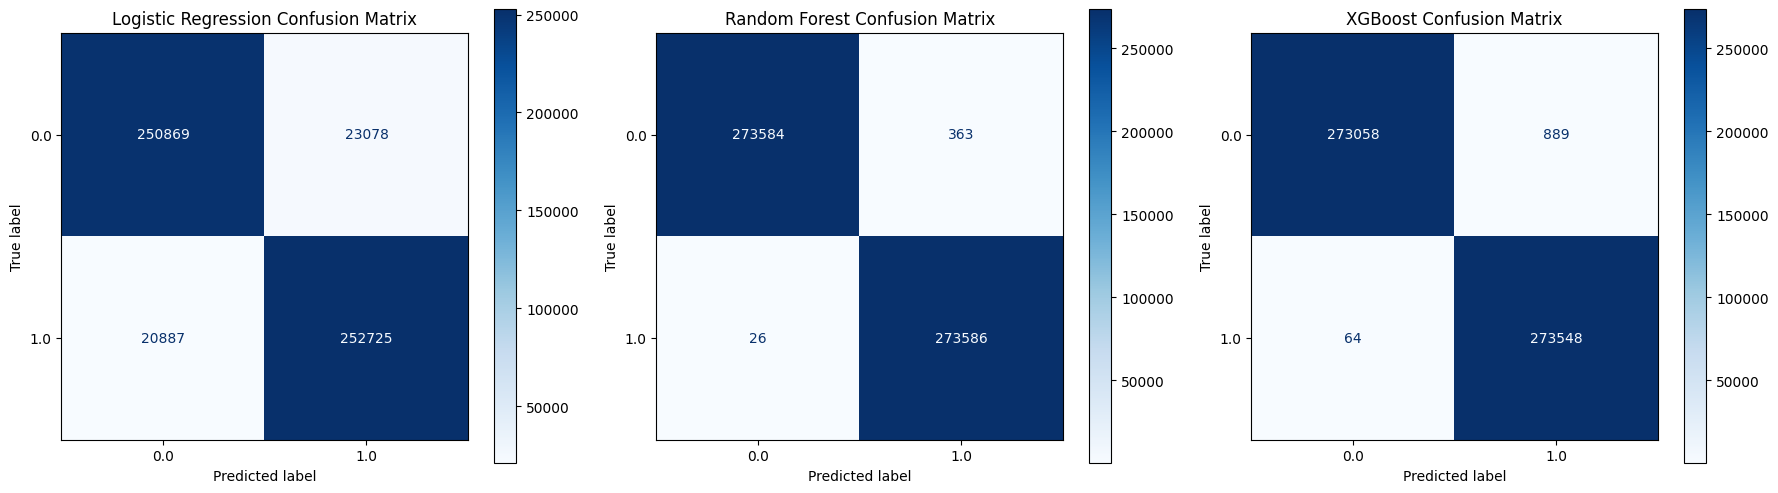

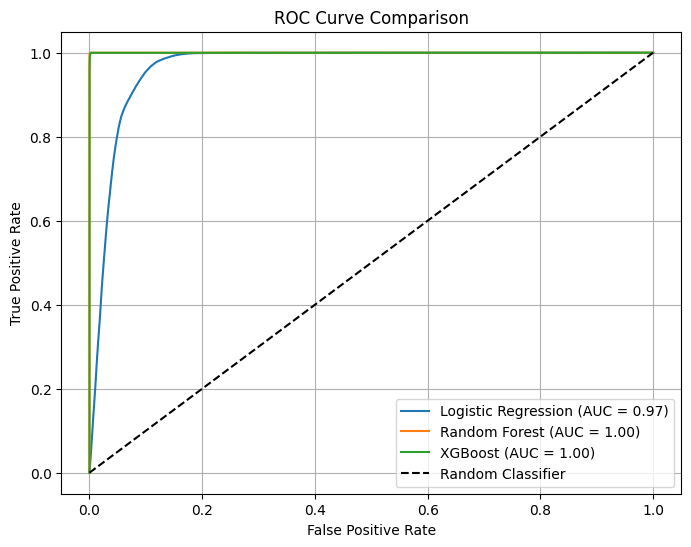

In [19]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Simplified evaluation function: print metrics + confusion matrix
def evaluate_model(name, y_true, y_pred, ax_cm=None):
    print(f"\n{name} Results")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred)
    print("AUC Score:", auc)

    # Confusion matrix plotting
    if ax_cm:
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax_cm, cmap='Blues')
        ax_cm.set_title(f'{name} Confusion Matrix')

# Generate probabilities for ROC curve
log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# ----------------------------
# 1. CONFUSION MATRIX PLOTS
# ----------------------------
fig_cm, axes_cm = plt.subplots(1, 3, figsize=(18, 5))

evaluate_model("Logistic Regression", y_test, log_preds, ax_cm=axes_cm[0])
evaluate_model("Random Forest", y_test, rf_preds, ax_cm=axes_cm[1])
evaluate_model("XGBoost", y_test, xgb_preds, ax_cm=axes_cm[2])

plt.tight_layout()
plt.show()

# ----------------------------
# 2. ROC CURVE COMPARISON PLOT
# ----------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

auc_log = roc_auc_score(y_test, log_probs)
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xgb = roc_auc_score(y_test, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Unsupervised Models

## Isolation Forest

In [20]:
iso = IsolationForest(contamination=0.05)
unsupervised_preds = iso.fit_predict(X_scaled)
unsupervised_preds = np.where(unsupervised_preds == -1, 1, 0)
print("Isolation Forest Accuracy:", accuracy_score(y, unsupervised_preds))


Isolation Forest Accuracy: 0.884047


## Autoencoder

In [21]:
X_normal = X_scaled[y == 0]
input_dim = X_scaled.shape[1]
encoding_dim = 5

# Build Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_normal, X_normal, epochs=10, batch_size=32, shuffle=True, verbose=1)

# Reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)
threshold = np.percentile(mse[y == 0], 95)
autoencoder_preds = (mse > threshold).astype(int)

print("Autoencoder Accuracy:", accuracy_score(y, autoencoder_preds))
print("Autoencoder AUC:", roc_auc_score(y, autoencoder_preds))


Epoch 1/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.6183
Epoch 2/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.6357
Epoch 3/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.5654
Epoch 4/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.5441
Epoch 5/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.5451
Epoch 6/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.5709
Epoch 7/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.5502
Epoch 8/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.5640
Epoch 9/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - loss: 0.5999
Epoch 10/10
28519/28519 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.5544
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
Autoencoder Accuracy: 0.885476
Autoencoder AUC: 0.5808830110746239


In [22]:
results_df = pd.DataFrame()
results_df['Actual_Fraud'] = y.reset_index(drop=True)

# Add predictions from all models
results_df['Logistic_Pred'] = pd.Series(log_preds)
results_df['RandomForest_Pred'] = pd.Series(rf_preds)
results_df['XGBoost_Pred'] = pd.Series(xgb_preds)

# Add unsupervised model predictions (full dataset)
results_df['IsolationForest_Pred'] = unsupervised_preds
results_df['Autoencoder_Pred'] = autoencoder_preds

# Show the first 10 rows
results_df.head(10)



,Actual_Fraud,Logistic_Pred,RandomForest_Pred,XGBoost_Pred,IsolationForest_Pred,Autoencoder_Pred
0,0.0,1.0,1.0,1.0,0,0
1,0.0,0.0,0.0,0.0,0,0
2,0.0,1.0,1.0,1.0,0,0
3,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0,0
5,0.0,1.0,1.0,1.0,0,0
6,0.0,1.0,1.0,1.0,0,0
7,0.0,0.0,0.0,0.0,0,0
8,0.0,1.0,1.0,1.0,0,1
9,0.0,0.0,0.0,0.0,0,0


# Comparison of Models (Before and After SMOTE)

In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [25]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest', 'Autoencoder']


accuracy_before = [accuracy_score(y_test_imb, log_preds_imb),
                   accuracy_score(y_test_imb, rf_preds_imb),
                   accuracy_score(y_test_imb, xgb_preds_imb),
                   accuracy_score(y, unsupervised_preds),
                   accuracy_score(y, autoencoder_preds)
                   ]

accuracy_after = [accuracy_score(y_test, log_preds),
                   accuracy_score(y_test, rf_preds),
                   accuracy_score(y_test, xgb_preds),
                   accuracy_score(y, unsupervised_preds),
                   accuracy_score(y, autoencoder_preds)
                   ]

precision_before = [precision_score(y_test_imb, log_preds_imb),
                   precision_score(y_test_imb, rf_preds_imb),
                   precision_score(y_test_imb, xgb_preds_imb),
                   precision_score(y, unsupervised_preds),
                   precision_score(y, autoencoder_preds)
                   ]

precision_after = [precision_score(y_test, log_preds),
                   precision_score(y_test, rf_preds),
                   precision_score(y_test, xgb_preds),
                   precision_score(y, unsupervised_preds),
                   precision_score(y, autoencoder_preds)
                   ]

recall_before = [recall_score(y_test_imb, log_preds_imb),
                   recall_score(y_test_imb, rf_preds_imb),
                   recall_score(y_test_imb, xgb_preds_imb),
                   recall_score(y, unsupervised_preds),
                   recall_score(y, autoencoder_preds)
                   ]

recall_after = [recall_score(y_test, log_preds),
                   recall_score(y_test, rf_preds),
                   recall_score(y_test, xgb_preds),
                   recall_score(y, unsupervised_preds),
                   recall_score(y, autoencoder_preds)
                   ]


f1_before = [f1_score(y_test_imb, log_preds_imb),
                   f1_score(y_test_imb, rf_preds_imb),
                   f1_score(y_test_imb, xgb_preds_imb),
                   f1_score(y, unsupervised_preds),
                   f1_score(y, autoencoder_preds)
                   ]

f1_after = [f1_score(y_test, log_preds),
                   f1_score(y_test, rf_preds),
                   f1_score(y_test, xgb_preds),
                   f1_score(y, unsupervised_preds),
                   f1_score(y, autoencoder_preds)
                   ]

roc_auc_before = [roc_auc_score(y_test_imb, log_preds_imb),
                   roc_auc_score(y_test_imb, rf_preds_imb),
                   roc_auc_score(y_test_imb, xgb_preds_imb),
                   roc_auc_score(y, unsupervised_preds),
                   roc_auc_score(y, autoencoder_preds)
                   ]

roc_auc_after = [roc_auc_score(y_test, log_preds),
                   roc_auc_score(y_test, rf_preds),
                   roc_auc_score(y_test, xgb_preds),
                   roc_auc_score(y, unsupervised_preds),
                   roc_auc_score(y, autoencoder_preds)
                   ]


columns = pd.MultiIndex.from_tuples([
    ('', 'Model'),
    ('Accuracy', 'Before SMOTE'),
    ('Accuracy', 'After SMOTE'),
    ('Precision', 'Before SMOTE'),
    ('Precision', 'After SMOTE'),
    ('Recall', 'Before SMOTE'),
    ('Recall', 'After SMOTE'),
    ('F1-Score', 'Before SMOTE'),
    ('F1-Score', 'After SMOTE'),
    ('ROC-AUC Score', 'Before SMOTE'),
    ('ROC-AUC Score', 'After SMOTE')
])

compare_data = list(zip(models, accuracy_before, accuracy_after,
                precision_before, precision_after,
                recall_before, recall_after,
                f1_before, f1_after,
                roc_auc_before, roc_auc_after))

compare_df = pd.DataFrame(compare_data, columns=columns)

final_compared_df = compare_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('border', '1px solid #ccc')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f9f9f9')]}
]).set_properties(**{
    'text-align': 'right'
}).set_caption("Model Performance Comparison (Before & After SMOTE)")

In [26]:
final_compared_df